In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload

In [2]:
#To reload functions - Keep in mind !
reload(IF)

<module 'Important_Functions' from '/home/ferrigno/Documents/Teaching/ap-lab-i-2022/notebooks/Important_Functions.py'>

## Importing data

In [3]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Getting GTIs

In [4]:
new_gti = IF.get_GTIs(Time_phase_file[2])

## Getting the event arrival times taking into account the orbital correction

In [5]:
#Setting up the parameters used by the Stingray documentation to correct the event arrival times
correct_orbital_time = IF.get_orbital_correction(Time_phase_file[1], 'orbit_t2.txt')

/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2022-10-30 21:34:13.258 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2022-10-30 21:34:13.259 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2022-10-30 21:34:13.260 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2022-10-30 21:34:13.430 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2022-10-30 21:34:13.442 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2022-10-30 21:34:14.709 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2022-10-30 21:34:14.715 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_obs

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

In [6]:
correct_list, guess_freq = IF.get_pulse_freq(0.208, 0.209, 1000, correct_orbital_time, new_gti, 20000)

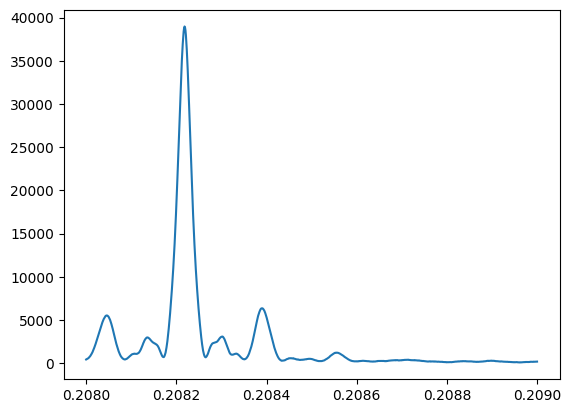

In [7]:
#Plotting the power as a function energy
plt.plot(correct_list[0], correct_list[1])
plt.show()

# Getting the pulse profile matrix with orbitally corrected time segments

# Getting the ENERGY pulse profile matrix

In [8]:
reload(IF)
energy_time_segments, energy_segments = IF.segment_energywise(correct_orbital_time, 
                                                              Time_phase_data['PI'], 120, 2800, -50)



In [ ]:
for i in range(50):
    plt.plot(energy_time_segments[i], energy_segments[i], '.')
    plt.show()

## Plotting the energy pulse profile matrix 

32
11
11
13
8
13
14
15
9
10
10
10
10
12
10
9
9
9
9
7
22
6
5
7
9
4
30
3
23
3
28
24
28


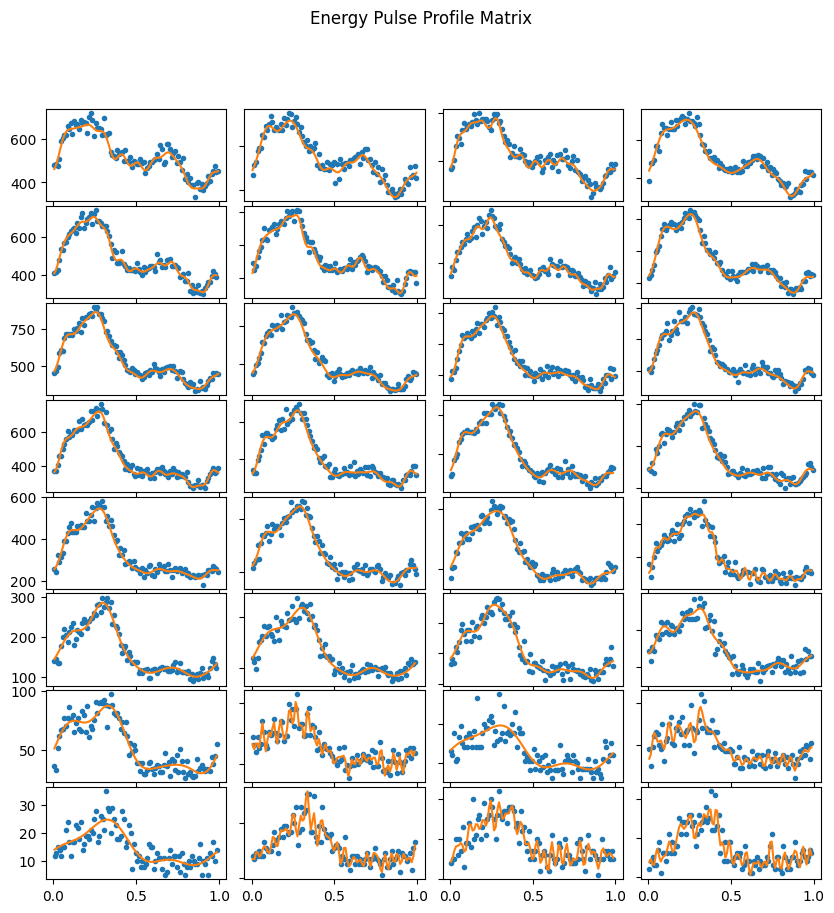

In [9]:
reload(IF)

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, 
                                                                                                 Time_phase_data['TIME'][0], 
                                                                                                 [guess_freq], True, 32, 0.01, 0.3)



In [10]:
print(len(energy_orders))

32


## Using bootstrap method to find the uncertainty on the phase 

## Re-making the bootstrapping method to be more general and calculating the phase and RMS for each energy pulse profile (i.e. making sure the new functions work)

In [16]:
reload(IF)
RMS_error = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    print('RMS is:',IF.RMS_calculator(energy_counts[i], energy_orders[i]), ' +/- ', RMS_error[i])
    print('First phase is:', IF.get_first_harmonic_phase(energy_counts[i]), ' +/- ', IF.bootstrap_total(energy_counts[i], 100, IF.get_first_harmonic_phase)) 
    print('\n')

ValueError: setting an array element with a sequence.

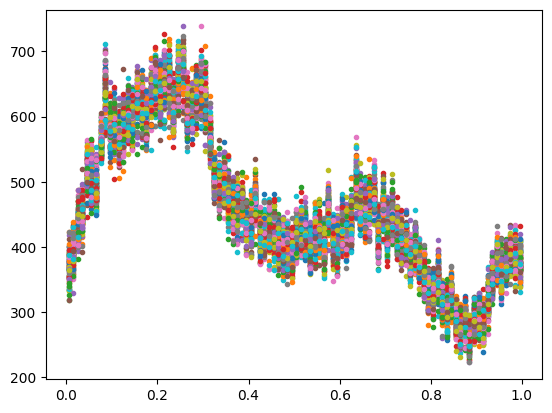

In [84]:
for i in range(100):
    plt.plot(energy_phasefold_time[3], IF.bootstrap_generate(energy_counts[3], 100)[i], '.')
plt.show()

## Plotting the RMS against energy 

Text(0.5, 1.0, 'Plot of the RMS against Energy for Bootstrap')

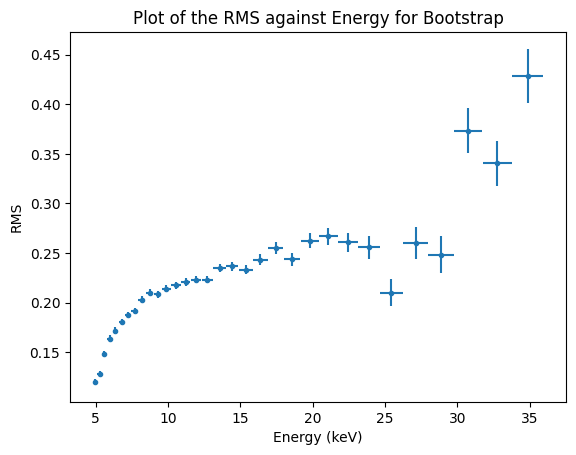

In [14]:
reload(IF)
RMSs = np.zeros(len(energy_counts))
avg = np.zeros(len(energy_counts))
avg_error = np.zeros(len(energy_counts))
RMS_error = np.ones(len(energy_counts))

for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    RMSs[i] = IF.RMS_calculator(energy_counts[i], energy_orders[i])
    avg[i] = np.mean(energy_segments[i])
    avg_error[i] = ( np.max(energy_segments[i]) - np.min(energy_segments[i]))/2.

#avg_error = np.array(avg)/np.sqrt(len(energy_counts))
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=avg_error, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy for Bootstrap')

#plt.savefig('/Users/samsonmercier/Desktop/RMS_vs_Energy.pdf')

In [24]:
n_phases=100
phases = np.linspace(0, 1, n_phases)

In [40]:
from nustarpipeline import utils
reload(utils)

<module 'nustarpipeline.utils' from '/home/ferrigno/Soft/nustar-pipeline/nustarpipeline/utils.py'>

0.2314470959790759

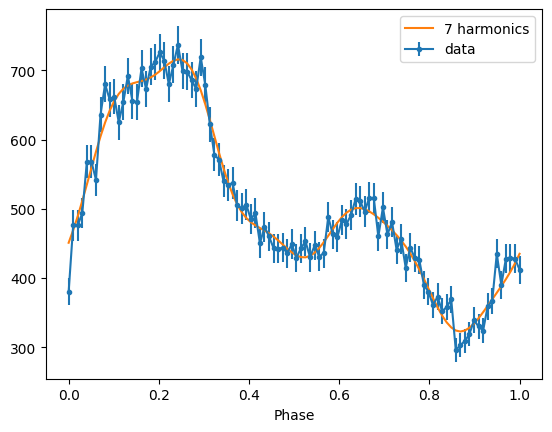

In [41]:
utils.fft_pulsed_fraction(energy_counts[3], np.sqrt(energy_counts[3]), plot=True)

In [42]:
utils.get_error_from_simul(energy_counts[3], np.sqrt(energy_counts[3]), utils.fft_pulsed_fraction, n_simul=1000)

0.00452252219818813

In [43]:
utils.get_error_from_simul(energy_counts[3], np.sqrt(energy_counts[3]), utils.fft_pulsed_fraction, 
                           n_simul=1000, use_poisson=True)

0.004787701846871881

/home/ferrigno/Soft/nustar-pipeline/nustarpipeline/utils.py:542: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0.5, 1.0, 'Plot of the RMS against Energy for Bootstrap')

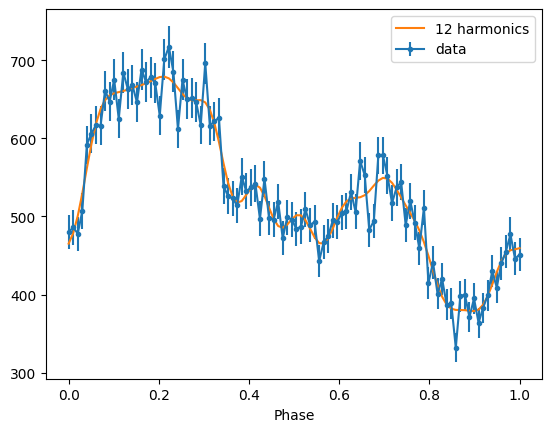

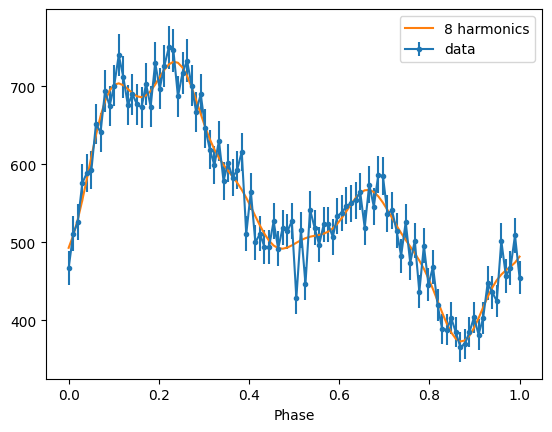

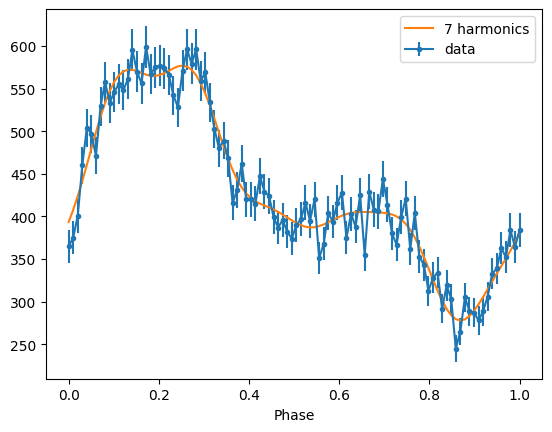

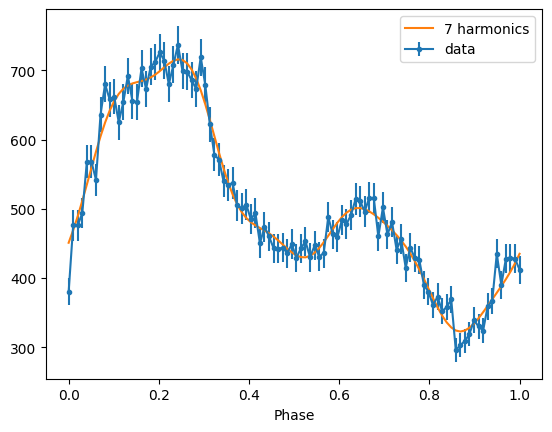

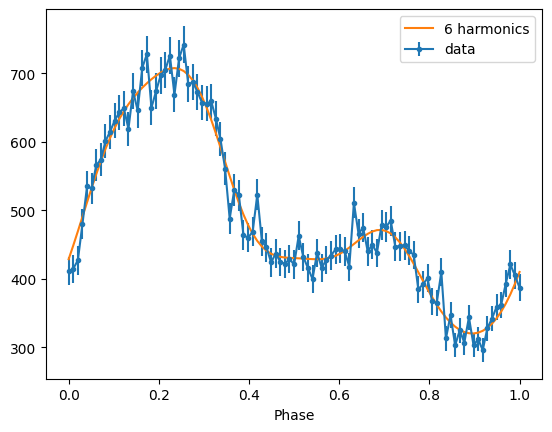

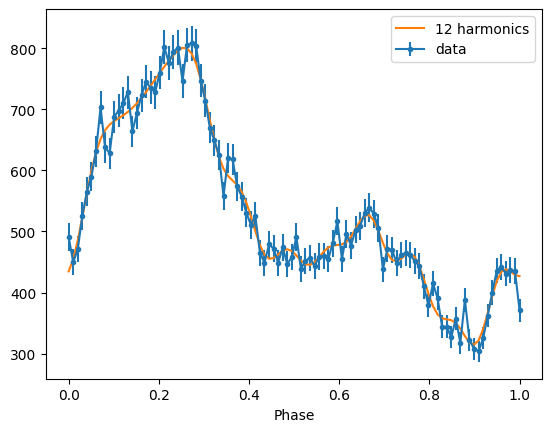

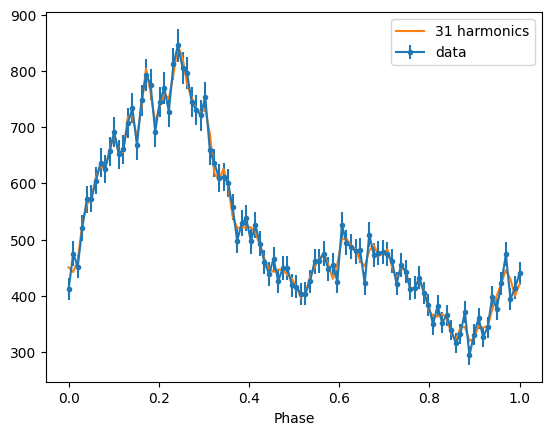

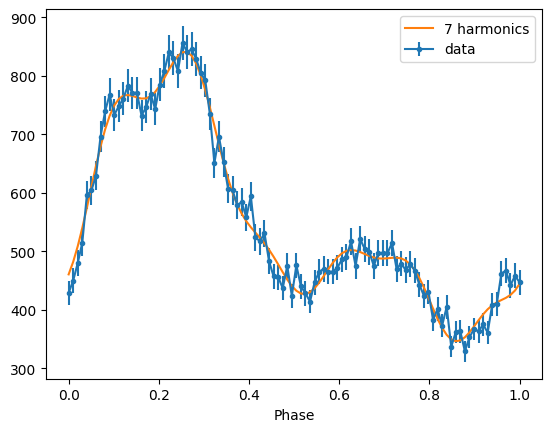

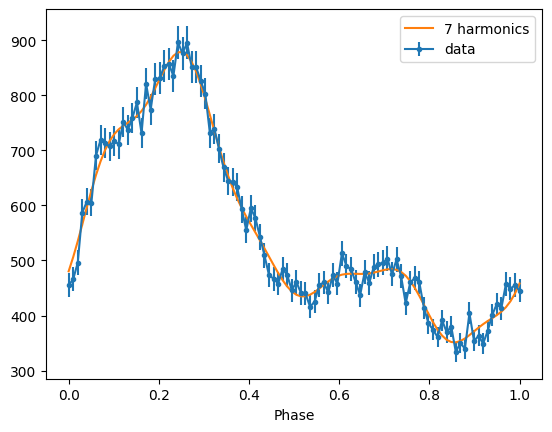

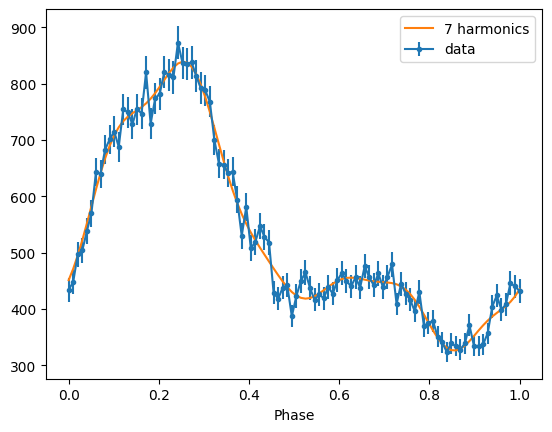

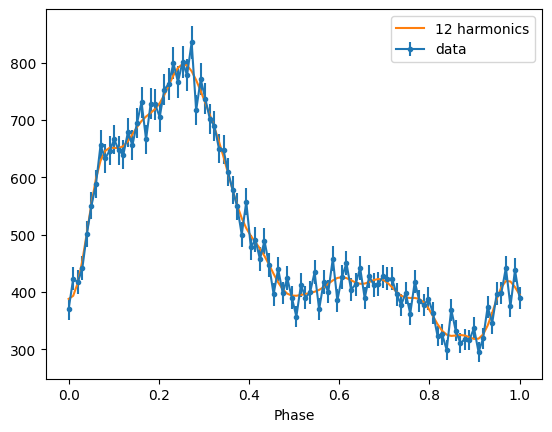

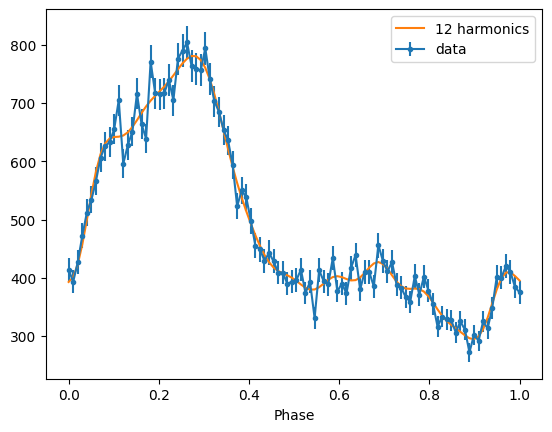

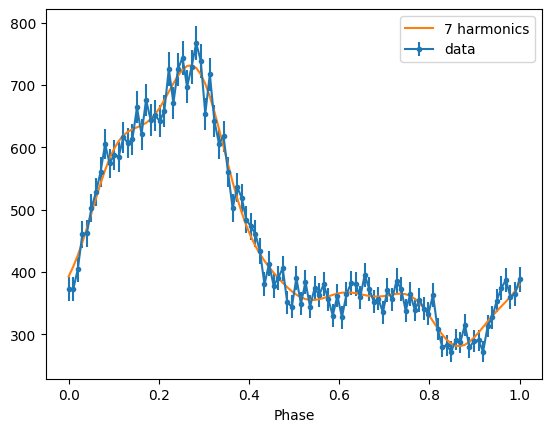

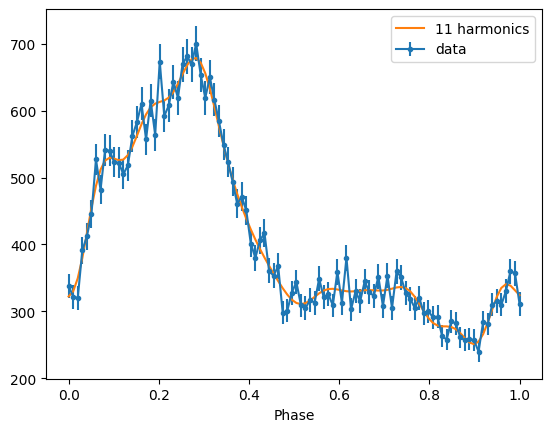

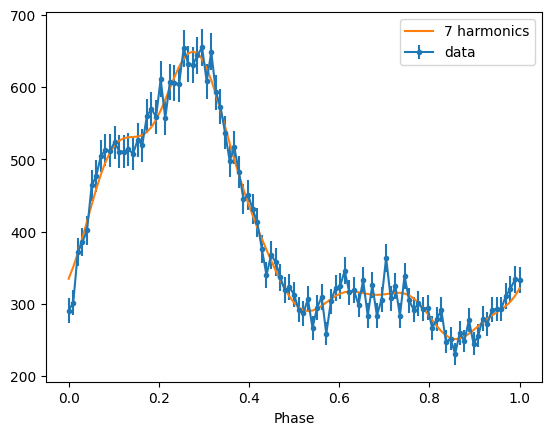

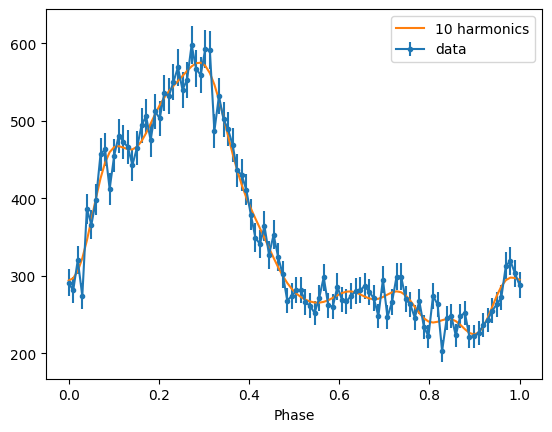

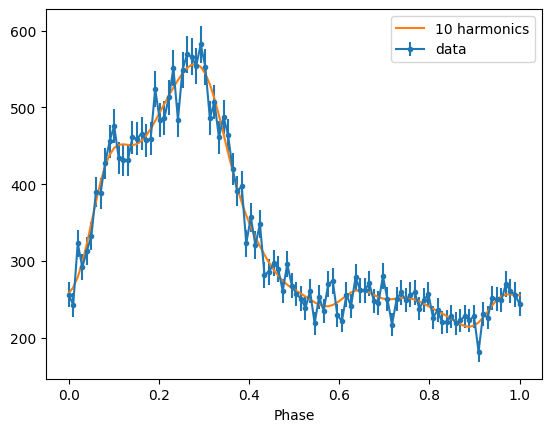

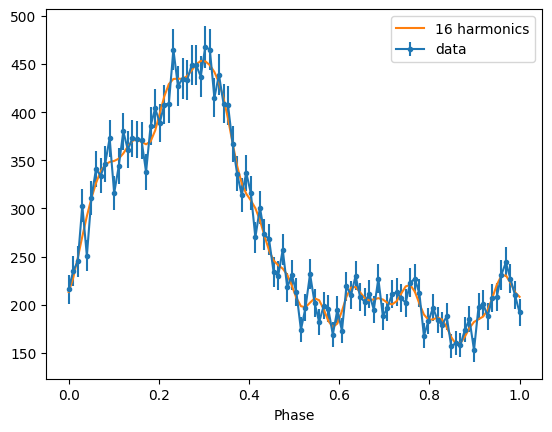

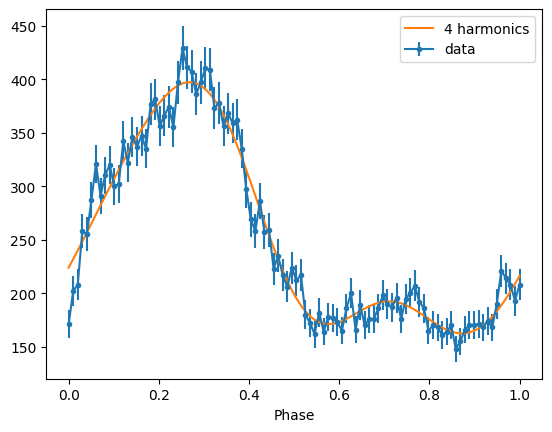

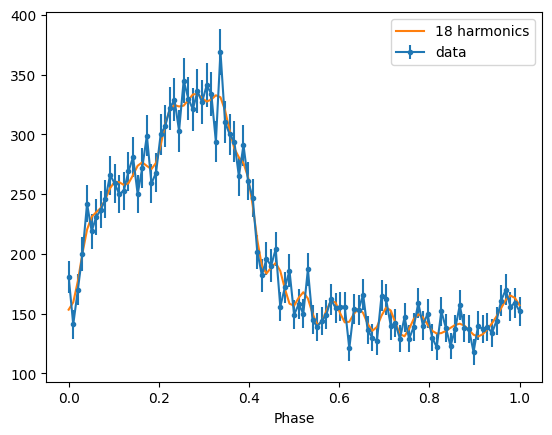

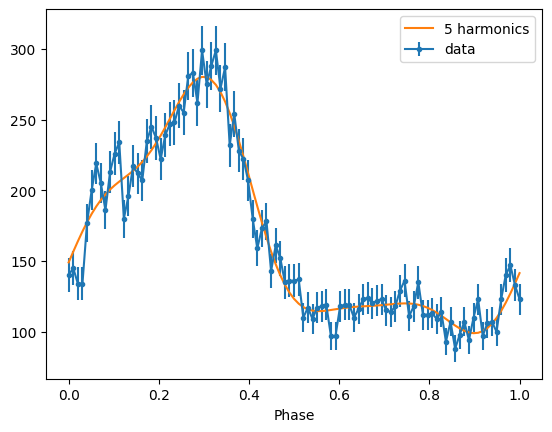

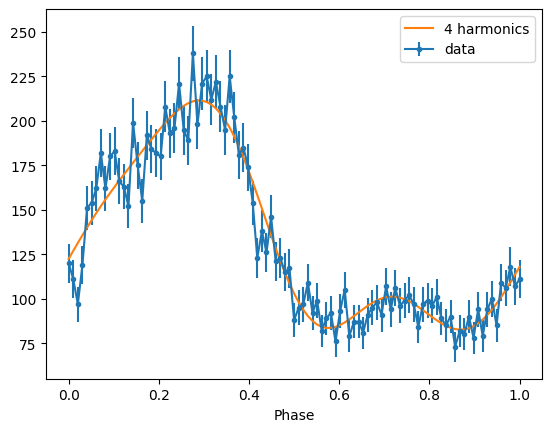

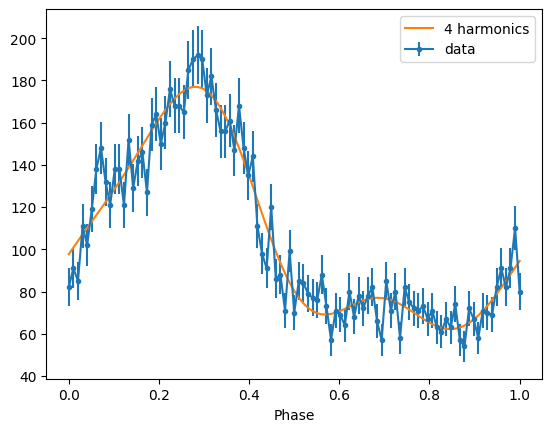

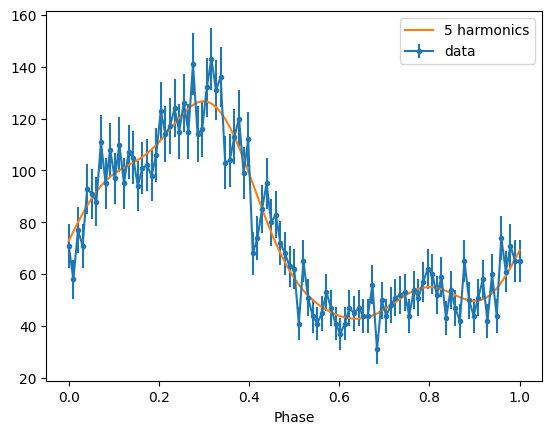

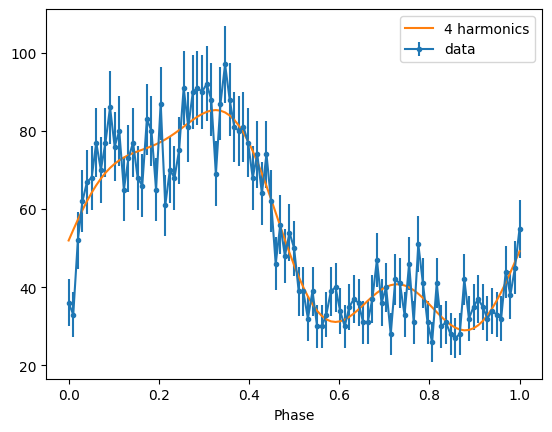

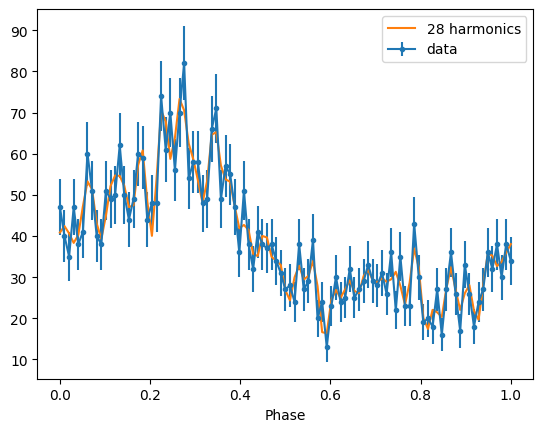

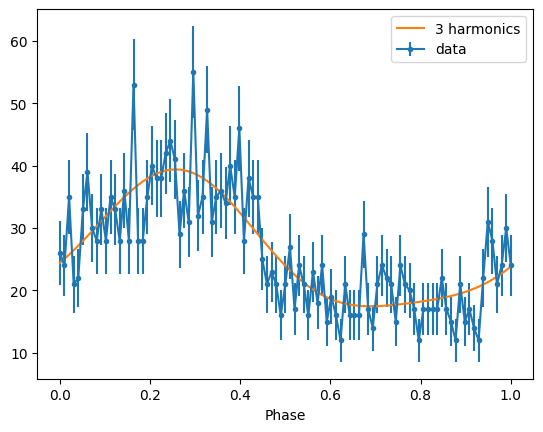

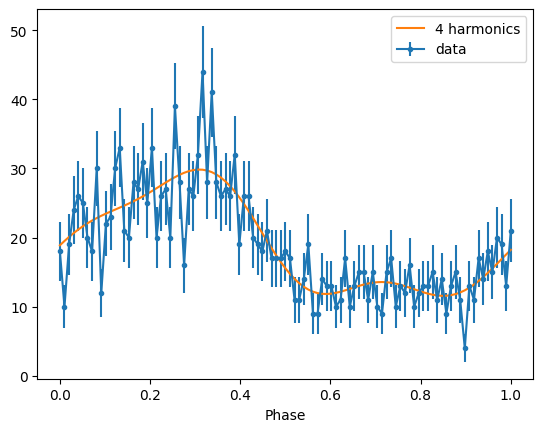

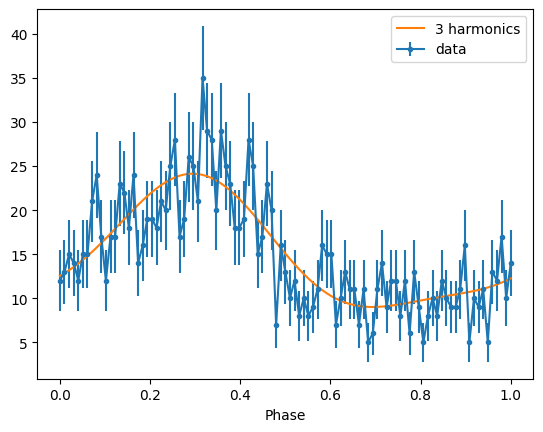

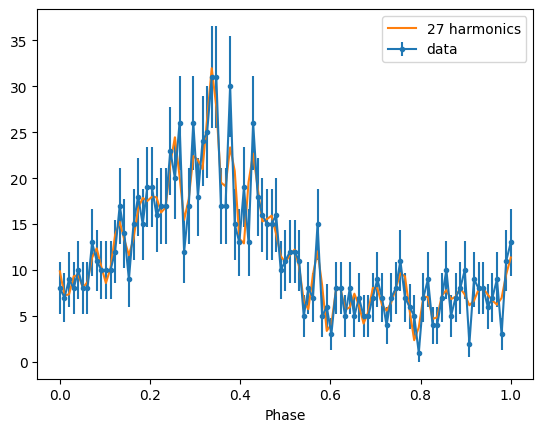

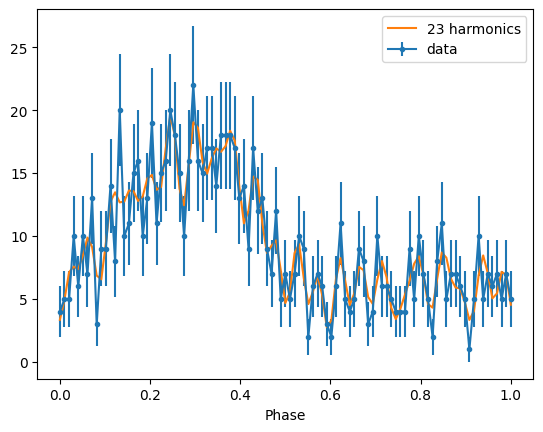

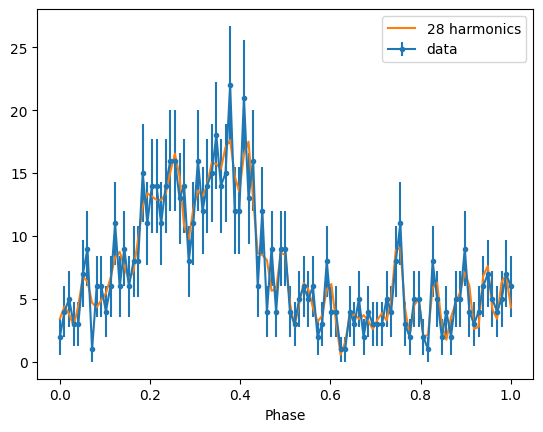

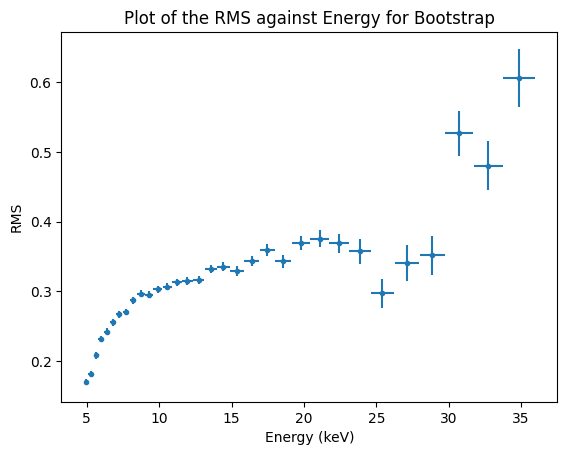

In [44]:
RMSs = np.zeros(len(energy_counts))
avg = np.zeros(len(energy_counts))
avg_error = np.zeros(len(energy_counts))
RMS_error = np.ones(len(energy_counts))

for i in range(len(energy_counts)):
    RMS_error[i] =utils.get_error_from_simul(energy_counts[i], np.sqrt(energy_counts[i]), 
                                                utils.fft_pulsed_fraction, 
                                                n_simul=1000, use_poisson=True)
    RMSs[i] = utils.fft_pulsed_fraction(energy_counts[i], np.sqrt(energy_counts[i]), plot=False)
    avg[i] = np.mean(energy_segments[i])
    avg_error[i] = ( np.max(energy_segments[i]) - np.min(energy_segments[i]))/2.

#avg_error = np.array(avg)/np.sqrt(len(energy_counts))
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=avg_error, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy for Bootstrap')